## Регрессия
Задача: предсказать зарплату игрока НХЛ по его статистике с использованием модели случайного леса.

Будем использовать MAE, так как она очень наглядная, будет легко понять, насколько долларов ошибается модель. В качестве дополнительной метрики будем использовать R^2, чтобы смотреть насколько отличается предсказание от среднего.

### Baseline Random Forest

In [806]:
import kagglehub
import pandas as pd


path = kagglehub.dataset_download(
    "camnugent/predict-nhl-player-salaries/versions/2"
)

df1 = pd.read_csv(path + "/train.csv")
df2 = pd.read_csv(path + "/test.csv")
salary = pd.read_csv(path + "/test_salaries.csv")

df2['Salary'] = salary['Salary'].values
df2 = df2[df1.columns]
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.00,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.00,1.00,...,1.00,0.00,-0.20,-0.20,40.03,1,0.00,175.70,-0.40,-0.38
1,2250000.00,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.00,1.00,...,98.00,-0.20,3.40,3.20,2850.59,290,13.30,112.50,14.10,0.18
2,8000000.00,88-04-16,St. Paul,MN,USA,USA,72,218,2006.00,1.00,...,70.00,3.70,1.30,5.00,2486.75,102,6.60,114.80,36.80,0.57
3,3500000.00,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.00,1.00,...,22.00,0.00,0.40,0.50,1074.41,130,17.50,105.10,5.90,0.20
4,1750000.00,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.00,1.00,...,68.00,-0.10,1.40,1.30,3459.09,425,8.30,99.50,21.80,0.27


In [807]:
df['Born'] = pd.to_datetime(df['Born'], format='%y-%m-%d')
df_clean = df.fillna(0)
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].astype('category').cat.codes
df_clean = df_clean.drop("Born", axis=1)

In [808]:
from sklearn.model_selection import train_test_split

TARGET_NAME = "Salary"
X = df_clean.drop(TARGET_NAME, axis=1)
y = df_clean[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [809]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

dt = RandomForestRegressor(random_state=42, max_depth=None, min_samples_leaf=1)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
base_mean_error = mean_absolute_error(y_test, np.full(len(y_test), y_train.mean()))

print("--- Decision Forest Regressor ---")
print(f"MAE (в тех же единицах, что и y): {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

--- Decision Forest Regressor ---
MAE (в тех же единицах, что и y): 973296.880
R2 Score: 0.604


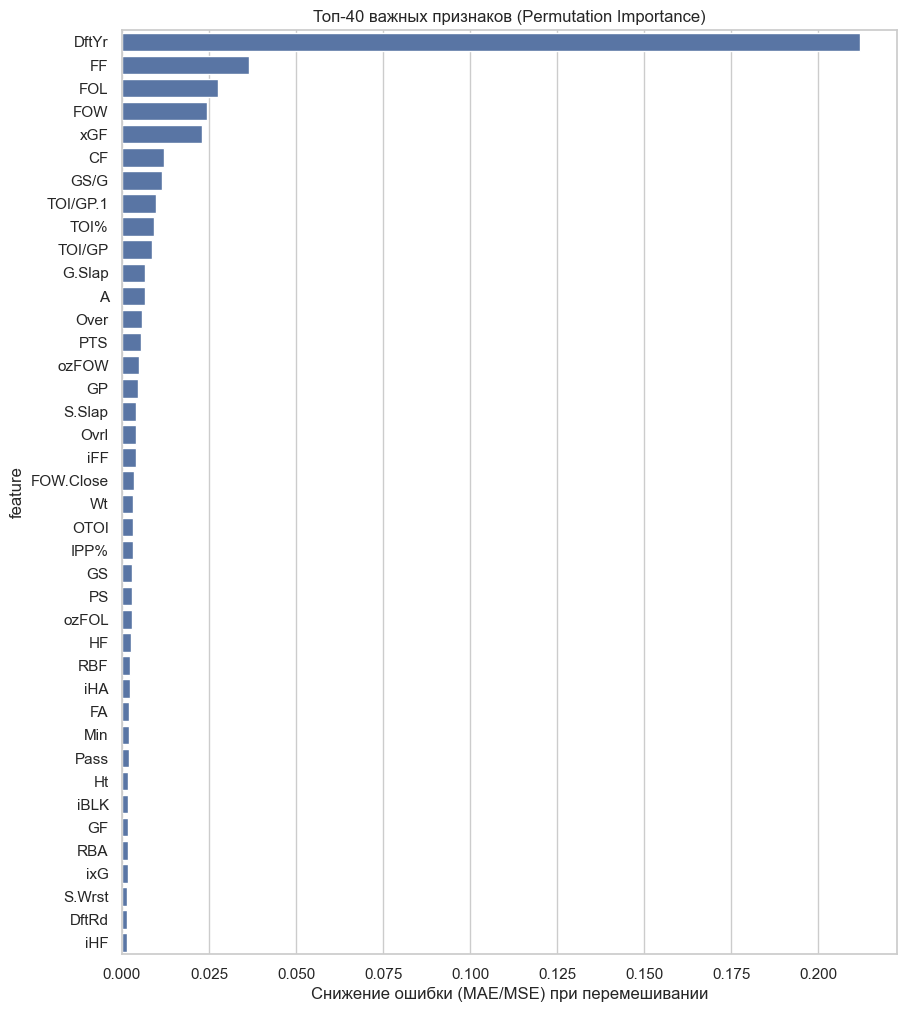

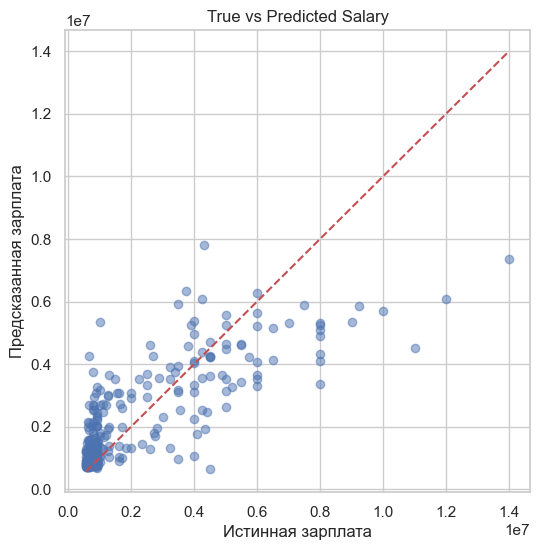

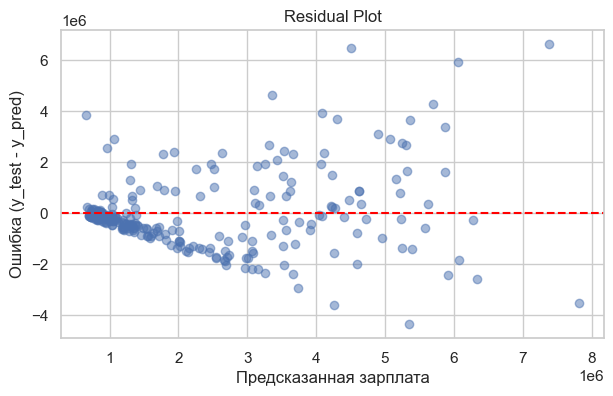

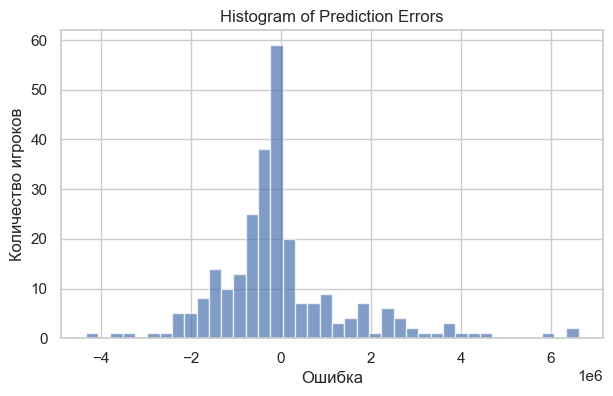

In [810]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.inspection import permutation_importance

def important_features(model, X_test, y_test):
    perm_result = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=10,
        random_state=52,
        n_jobs=-1
    )

    perm_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': perm_result.importances_mean
    })

    top_40_perm = perm_df.sort_values(by='importance', ascending=False).head(40)

    plt.figure(figsize=(10, 12))
    sns.barplot(data=top_40_perm, x='importance', y='feature')
    plt.title("Топ-40 важных признаков (Permutation Importance)")
    plt.xlabel("Снижение ошибки (MAE/MSE) при перемешивании")
    plt.show()

def true_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Истинная зарплата")
    plt.ylabel("Предсказанная зарплата")
    plt.title("True vs Predicted Salary")
    plt.grid(True)
    plt.show()

def resudial(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(7,4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Предсказанная зарплата")
    plt.ylabel("Ошибка (y_test - y_pred)")
    plt.title("Residual Plot")
    plt.grid(True)
    plt.show()
def histogramm_error(y_test, y_pred):
    plt.figure(figsize=(7,4))
    residuals = y_test - y_pred
    plt.hist(residuals, bins=40, alpha=0.7)
    plt.title("Histogram of Prediction Errors")
    plt.xlabel("Ошибка")
    plt.ylabel("Количество игроков")
    plt.grid(True)
    plt.show()


important_features(dt, X_test, y_test)
true_vs_predicted(y_test, y_pred)
resudial(y_test, y_pred)
histogramm_error(y_test, y_pred)

Случайный лес более адаптивная и продвинутая модель по сравнении с решающим деревом. Даже при необработанных данных она даёт неплохой результат. Видим, что точки более сконцентированы рядом с осью, однако большие зарплаты лесу тяжело предугадать: если не было в обучающей выборке, значит она просто не может дать подобный результат.

### Improved Random Forest

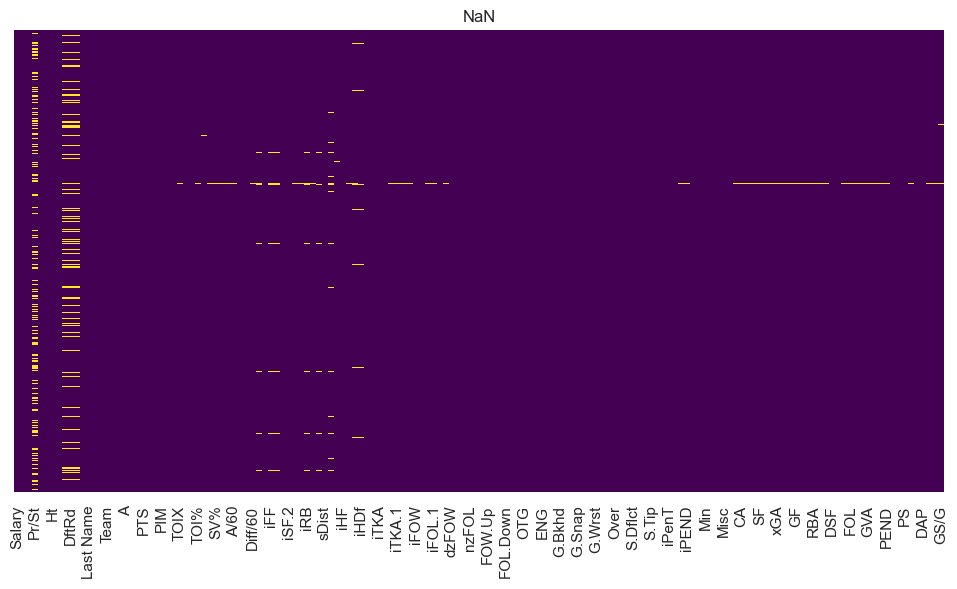

In [811]:
import kagglehub
from matplotlib import pyplot as plt
import seaborn as sns

path = kagglehub.dataset_download(
    "camnugent/predict-nhl-player-salaries/versions/2"
)

df1 = pd.read_csv(path + "/train.csv")
df2 = pd.read_csv(path + "/test.csv")
salary = pd.read_csv(path + "/test_salaries.csv")
df2['Salary'] = salary['Salary'].values
df2 = df2[df1.columns]
df = pd.concat([df1, df2], ignore_index=True)

nulls = df.isna().sum().sort_values(ascending=False)
null_pct = (nulls / len(df)).mul(100).round(2)

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("NaN")
plt.show()

In [812]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Salary,874.00,2325288.71,2298252.56,575000.00,742500.00,925000.00,3700000.00,14000000.00
Ht,874.00,73.08,2.11,66.00,72.00,73.00,75.00,81.00
Wt,874.00,200.84,15.06,157.00,190.00,200.00,210.00,265.00
DftYr,749.00,2008.71,4.38,1990.00,2006.00,2010.00,2012.00,2016.00
DftRd,749.00,2.74,1.99,1.00,1.00,2.00,4.00,9.00
...,...,...,...,...,...,...,...,...
Grit,874.00,126.78,101.61,0.00,41.00,114.00,190.00,622.00
DAP,874.00,9.22,7.82,0.00,4.60,7.60,12.00,61.00
Pace,873.00,108.94,8.90,75.00,104.70,109.20,113.90,175.70
GS,873.00,21.87,21.99,-4.30,2.60,15.70,35.40,104.70


In [813]:
import pandas as pd
import numpy as np

num_cols = df.select_dtypes(include=["int64", "float64"]).columns

corr_matrix = df[num_cols].corr()

corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['feature_1', 'feature_2', 'correlation']

corr_pairs = corr_pairs[corr_pairs['feature_1'] < corr_pairs['feature_2']]

corr_pairs = corr_pairs.reindex(
    corr_pairs['correlation'].abs().sort_values(ascending=False).index
)

top40 = corr_pairs.head(40)

display(top40)
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper_corr = corr_matrix.where(upper)
to_drop = [col for col in upper_corr.columns if any(upper_corr[col] > 0.998)]

df_clean = df.drop(columns=to_drop)

df_clean.head()

,feature_1,feature_2,correlation
4931,iSF.1,iSF.2,1.00
8267,iFOL,iFOL.1,1.00
8122,iFOW,iFOW.1,1.00
6381,iHF,iHF.1,1.00
2321,TOI,TOIX,1.00
7398,iBLK,iBLK.1,1.00
4787,iSF,iSF.2,1.00
4786,iSF,iSF.1,1.00
7108,iGVA,iGVA.1,1.00
7253,iTKA,iTKA.1,1.00


,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.00,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.00,1.00,...,1.00,0.00,-0.20,-0.20,40.03,1,0.00,175.70,-0.40,-0.38
1,2250000.00,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.00,1.00,...,98.00,-0.20,3.40,3.20,2850.59,290,13.30,112.50,14.10,0.18
2,8000000.00,88-04-16,St. Paul,MN,USA,USA,72,218,2006.00,1.00,...,70.00,3.70,1.30,5.00,2486.75,102,6.60,114.80,36.80,0.57
3,3500000.00,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.00,1.00,...,22.00,0.00,0.40,0.50,1074.41,130,17.50,105.10,5.90,0.20
4,1750000.00,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.00,1.00,...,68.00,-0.10,1.40,1.30,3459.09,425,8.30,99.50,21.80,0.27


In [814]:
df_features = df_clean.copy()

df_features['Born'] = pd.to_datetime(df_features['Born'], format='%y-%m-%d')
reference_date = pd.Timestamp('2016-10-01')
df_features['Age'] = (reference_date - df_features['Born']).dt.days / 365.25

df_features['Experience'] = reference_date.year - df_features['DftYr']
df_features['Age_squared'] = df_features['Age'] ** 2
df_features['G_per_GP'] = df_features['G'] / df_features['GP'].replace(0, 1)
df_features['A_per_GP'] = df_features['A'] / df_features['GP'].replace(0, 1)
df_features['PTS_per_GP'] = df_features['PTS'] / df_features['GP'].replace(0, 1)
df_features['Is_Drafted'] = df_features['DftYr'].notna().astype(int)
df_features['Physical_Impact'] = df_features['Wt'] * df_features['Ht']

features_to_drop = ['Born', 'Last Name', 'First Name', 'Nat', 'Pr/St', 'City']
df_features = df_features.drop(features_to_drop, axis=1)
df_features['Match'].value_counts()

Match
0    870
1      4
Name: count, dtype: int64

In [815]:
has_nan = df_features.isnull().any()

columns_with_nan = has_nan[has_nan].index.tolist()

print("Столбцы, содержащие хотя бы один NaN:")
columns_with_nan

Столбцы, содержащие хотя бы один NaN:


['DftYr',
 'DftRd',
 'Ovrl',
 'TOI%',
 'IPP%',
 'SH%',
 'SV%',
 'PDO',
 'F/60',
 'A/60',
 'Diff/60',
 'iCF',
 'iFF',
 'iSF',
 'ixG',
 'iSCF',
 'iRB',
 'iRS',
 'iDS',
 'sDist.1',
 'Pass',
 'iHA',
 'iHDf',
 'BLK%',
 '%FOT',
 'iPENT',
 'iPEND',
 'CF',
 'CA',
 'xGF',
 'xGA',
 'SCF',
 'SCA',
 'GF',
 'GA',
 'RBF',
 'RBA',
 'RSF',
 'RSA',
 'FOW',
 'FOL',
 'HF',
 'HA',
 'GVA',
 'TKA',
 'PENT',
 'PEND',
 'OTOI',
 'Pace',
 'GS',
 'GS/G',
 'Experience']

In [816]:
TARGET_NAME = 'Salary'

X_i = df_features.drop(TARGET_NAME, axis=1)
y_i = df_features[TARGET_NAME]

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_i, y_i, test_size=0.2, random_state=42
)

In [817]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

cat_cols = X_i.select_dtypes(include=['object', 'category']).columns.tolist()

cat_branch = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

num_cols = X_i.select_dtypes(include=["int64", "float64"]).columns

num_branch = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

ct = ColumnTransformer(
    transformers=[
        ("cat_proc", cat_branch, cat_cols),
        ("num_proc", num_branch, num_cols),
    ], remainder='drop'
)

In [818]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import TransformedTargetRegressor
import numpy as np

full_pipeline = Pipeline([
    ('preprocessor', ct),
    ('model_wrapper', TransformedTargetRegressor(
        regressor=RandomForestRegressor(random_state=52),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

param_grid = {
    'model_wrapper__regressor__n_estimators': [200, 400, 800],

    'model_wrapper__regressor__max_depth': [3, 5, 7],
    'model_wrapper__regressor__min_samples_leaf': [7, 10, 15],
    'model_wrapper__regressor__min_samples_split': [2, 5, 10],

    'model_wrapper__regressor__max_features': ['sqrt', 'log2', 0.5],

    'model_wrapper__regressor__bootstrap': [True, False],
    'model_wrapper__regressor__max_samples': [0.6, 0.8, None],
}

grid = RandomizedSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    n_iter=50
)

grid.fit(X_train_i, y_train_i)

print("Лучшие параметры:", grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test_i)
y_pred_train = grid.best_estimator_.predict(X_train_i)

mae = mean_absolute_error(y_test_i, y_pred)
train_mae = mean_absolute_error(y_train_i, y_pred_train)
r2 = r2_score(y_test_i, y_pred)

print(f"\n--- Random Forest Regressor ---")
print(f"MAE: {mae:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"R2 Score: {r2:.3f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
85 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
85 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  Fi

Лучшие параметры: {'model_wrapper__regressor__n_estimators': 400, 'model_wrapper__regressor__min_samples_split': 2, 'model_wrapper__regressor__min_samples_leaf': 7, 'model_wrapper__regressor__max_samples': None, 'model_wrapper__regressor__max_features': 0.5, 'model_wrapper__regressor__max_depth': 7, 'model_wrapper__regressor__bootstrap': True}

--- Random Forest Regressor ---
MAE: 886212.124
Train MAE: 612650.674
R2 Score: 0.634


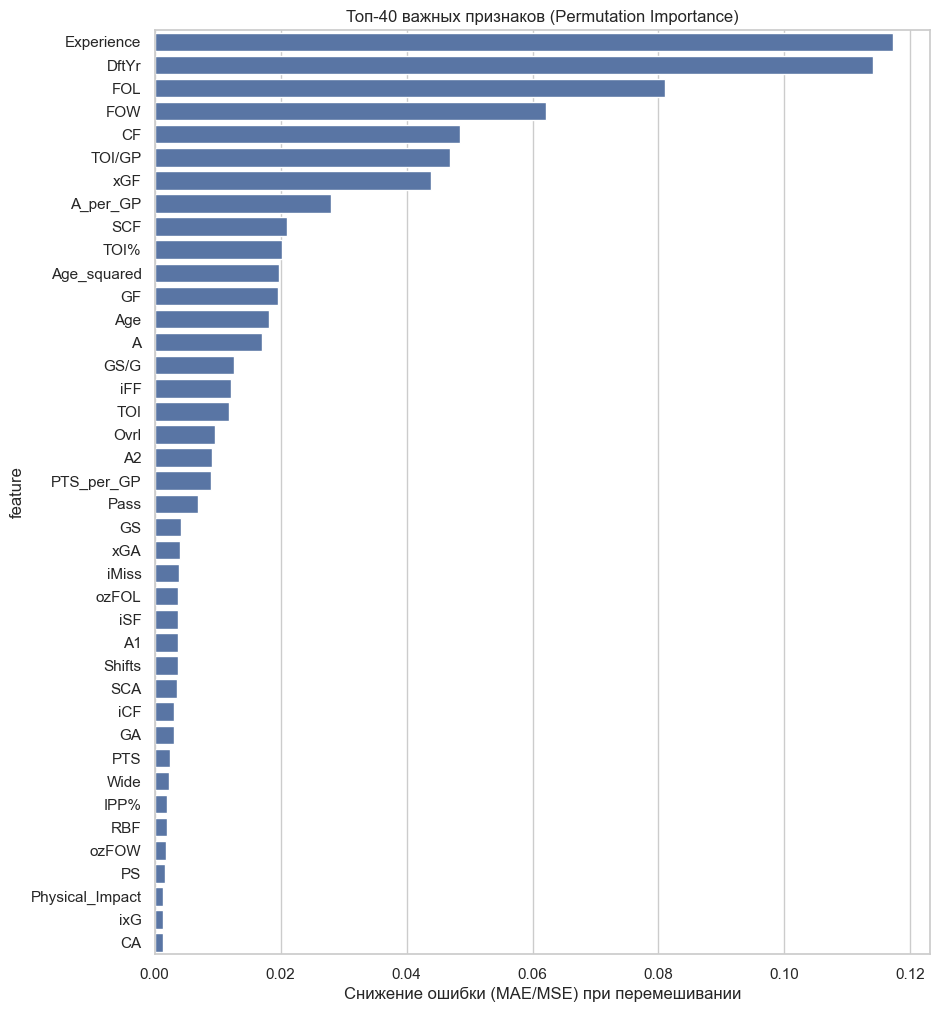

In [819]:
important_features(grid.best_estimator_, X_test_i, y_test_i)

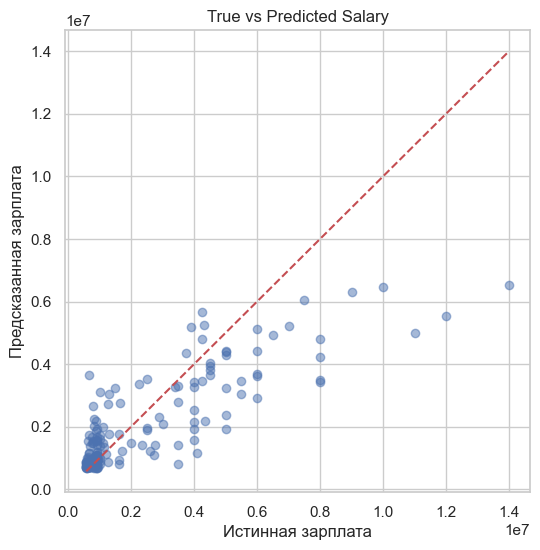

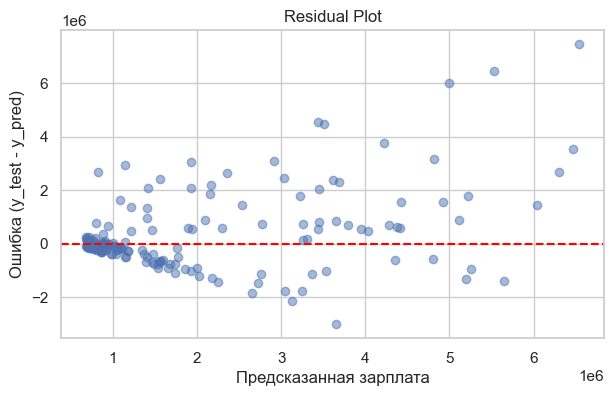

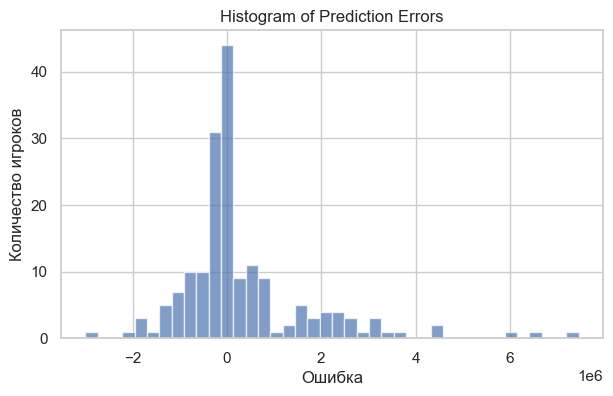

In [820]:
true_vs_predicted(y_test_i, y_pred)
resudial(y_test_i, y_pred)
histogramm_error(y_test_i, y_pred)

Решающее дерево оказывается немного хуже обычной линейной регрессии. Деревьям и лесу тяжело видимо работать с такими данными. Данных немного, поэтому в тестовой выборке он может не увидеть некоторых игроков с большими зарплатами, как следствие, лесу становиться плохо при работе с очень большими зарплатами, он склонен их занижать, в то время как модели линейной регрессии могут лучше обрабатывать такие выбросы.

Стоит отметить, что при меньших зарплатах, лесные модели показывают лучший скор, что видно по графику выше, предсказания явно более кучные относительно главной диагонали.

In [821]:
import pandas as pd
import numpy as np

original_float_format = pd.get_option('display.float_format')

pd.set_option('display.float_format', '{:.2f}'.format)

best_model = grid.best_estimator_

y_full_pred = best_model.predict(X_i)

results_df = pd.DataFrame({
    'True_Salary': y_i,
    'Predicted_Salary': y_full_pred
})

results_df['Absolute_Error'] = np.abs(results_df['True_Salary'] - results_df['Predicted_Salary'])

test_indices = X_test.index
final_results = pd.merge(
    df[['First Name', 'Last Name']],
    results_df,
    left_index=True,
    right_index=True
)

final_results_sorted = final_results.sort_values(by='Absolute_Error', ascending=False)

print("\n--- Топ-10 игроков с наибольшей ошибкой (Train & Test) ---")
print(final_results_sorted.head(10).to_string())

pd.set_option('display.float_format', original_float_format)


--- Топ-10 игроков с наибольшей ошибкой (Train & Test) ---
    First Name Last Name  True_Salary  Predicted_Salary  Absolute_Error
626       Anze   Kopitar  14000000.00        6541257.70      7458742.30
817     Steven   Stamkos   9500000.00        2208995.01      7291004.99
103    Patrick      Kane  13800000.00        7108861.82      6691138.18
542       Shea     Weber  12000000.00        5524412.38      6475587.62
496   Jonathan     Toews  13800000.00        7500248.59      6299751.41
208       P.K.    Subban  11000000.00        4994990.87      6005009.13
837       Ryan  O'Reilly  11000000.00        5936630.09      5063369.91
868       Loui  Eriksson   8000000.00        3440770.68      4559229.32
497     Andrew      Ladd   8000000.00        3505520.90      4494479.10
564       Ryan  Callahan   6500000.00        2168058.66      4331941.34


In [822]:
import pandas as pd
final_results['Signed_Error'] = final_results['Predicted_Salary'] - final_results['True_Salary']

overestimated_players = final_results[final_results['Signed_Error'] > 0].copy()

top_overestimated = overestimated_players.sort_values(by='Signed_Error', ascending=False)

print("\n--- Топ-10 игроков с наибольшей переоценкой зарплаты (Predicted > True) ---")

print(top_overestimated[['First Name', 'Last Name',
                         'True_Salary', 'Predicted_Salary', 'Signed_Error']].head(10).to_string())


--- Топ-10 игроков с наибольшей переоценкой зарплаты (Predicted > True) ---
    First Name Last Name  True_Salary  Predicted_Salary  Signed_Error
849        Sam    Gagner    650000.00        3653183.13    3003183.13
532      Radim    Vrbata   1000000.00        3409162.47    2409162.47
830    Patrick     Eaves   1000000.00        3338297.25    2338297.25
110       Luke    Schenn   1000000.00        3123907.82    2123907.82
150       Eric     Staal   3500000.00        5374237.17    1874237.17
665     Justin   Schultz   1400000.00        3267360.98    1867360.98
302        Tom     Pyatt    800000.00        2652198.09    1852198.09
5        Brian  Campbell   1500000.00        3247829.96    1747829.96
44        Paul     Byron   1300000.00        3046688.91    1746688.91
659     Artemi   Panarin    925000.00        2652047.46    1727047.46


### My implementation

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils import check_random_state

class MyRandomForestRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        n_estimators=100,
        max_depth=None,
        min_samples_leaf=1,
        max_features="sqrt",
        bootstrap=True,
        random_state=None
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.trees_ = []
        self.feature_subsets_ = []

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        n_samples, n_features = X.shape

        rng = check_random_state(self.random_state)

        if self.max_features == "sqrt":
            n_sub_features = int(np.sqrt(n_features))
        elif self.max_features == "log2":
            n_sub_features = int(np.log2(n_features))
        elif isinstance(self.max_features, int):
            n_sub_features = self.max_features
        elif self.max_features is None:
            n_sub_features = n_features
        else:
            raise ValueError("Invalid max_features")

        for _ in range(self.n_estimators):
            if self.bootstrap:
                sample_idx = rng.choice(n_samples, n_samples, replace=True)
            else:
                sample_idx = np.arange(n_samples)

            X_sample = X[sample_idx]
            y_sample = y[sample_idx]

            feature_idx = rng.choice(n_features, n_sub_features, replace=False)
            self.feature_subsets_.append(feature_idx)

            X_sample_small = X_sample[:, feature_idx]

            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf
            )
            tree.fit(X_sample_small, y_sample)

            self.trees_.append(tree)

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        predictions = []

        for tree, feat_idx in zip(self.trees_, self.feature_subsets_):
            X_small = X[:, feat_idx]
            predictions.append(tree.predict(X_small))

        return np.mean(predictions, axis=0)


In [824]:
dt = MyRandomForestRegressor(random_state=42, max_depth=None, min_samples_leaf=1)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
base_mean_error = mean_absolute_error(y_test, np.full(len(y_test), y_train.mean()))

print("--- Decision Forest Regressor ---")
print(f"MAE (в тех же единицах, что и y): {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

--- Decision Forest Regressor ---
MAE (в тех же единицах, что и y): 1122731.745
R2 Score: 0.481


In [825]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import TransformedTargetRegressor
import numpy as np

full_pipeline = Pipeline([
    ('preprocessor', ct),
    ('model_wrapper', TransformedTargetRegressor(
        regressor=MyRandomForestRegressor(),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

param_grid = {
    'model_wrapper__regressor__max_depth': [3, 5],
    'model_wrapper__regressor__min_samples_leaf': [10, 15],
}

grid = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_i, y_train_i)

print("Лучшие параметры:", grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test_i)
y_pred_train = grid.best_estimator_.predict(X_train_i)

mae = mean_absolute_error(y_test_i, y_pred)
train_mae = mean_absolute_error(y_train_i, y_pred_train)
r2 = r2_score(y_test_i, y_pred)

print(f"\n--- Decision Tree Regressor ---")
print(f"MAE: {mae:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"R2 Score: {r2:.3f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Лучшие параметры: {'model_wrapper__regressor__max_depth': 5, 'model_wrapper__regressor__min_samples_leaf': 10}

--- Decision Tree Regressor ---
MAE: 1116090.756
Train MAE: 910502.249
R2 Score: 0.420


Мой лес для регрессии получился сильно хуже, чем у scikit-learn. Это базовая имплементация, которая просто берёт среднее по всем деревьям, а библиотечная реализация использует дополнительно weighted averaging, out-of-bag estimation, subspace sampling, fast impurity reduction. И прунинга нет, конечно.

|     | Base Random Forest | Random Forest | My Random Forest |
|-----|--------------------|---------------|------------------|
| MAE | 973296.880         | 903145.338    | 1106530.124      |
| R2  | 0.604              | 0.617         | 0.432            |

## Классификация
Задача: вычислить мошенника на страховых выплатах с использованием модели случайного леса

Для выполнения лабораторной работы были выбраны метрики F1-score и ROC-AUC, так как исследуемый датасет является несбалансированным. Метрика Accuracy в данном случае неинформативна, так как модель, предсказывающая всем класс ‘0’ (не фрод), может иметь высокую Accuracy, но будет бесполезна. F1-score позволит контролировать баланс между ложными срабатываниями и пропуском мошенников.

### Baseline

In [826]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "buntyshah/auto-insurance-claims-data/versions/1",
                                  "insurance_claims.csv")
df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,...,?,87200,17440,8720,61040,Honda,Accord,2006,N,NaN
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,...,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N,NaN
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,...,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,NaN
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,...,YES,46980,5220,5220,36540,Audi,A5,1998,N,NaN


In [827]:
df_clean = df.copy()

TARGET_NAME = "fraud_reported"
df_clean["fraud_reported"] = df_clean["fraud_reported"].map({'Y': 1, 'N': 0})
df_clean["police_report_available"] = df_clean["police_report_available"].map({'YES': 1, 'NO': 0}).fillna(-1)
df_clean["property_damage"] = df_clean["police_report_available"].map({'YES': 1, 'NO': 0}).fillna(-1)

In [828]:
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].astype('category').cat.codes
df_clean.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,940,2,1,1000,1406.91,0,466132,...,1.00,71610,6510,13020,52080,10,1,2004,1,NaN
1,228,42,342868,635,1,1,2000,1197.22,5000000,468176,...,-1.00,5070,780,780,3510,8,12,2007,1,NaN
2,134,29,687698,413,2,0,2000,1413.14,5000000,430632,...,0.00,34650,7700,3850,23100,4,30,2007,0,NaN
3,256,41,227811,19,0,1,2000,1415.74,6000000,608117,...,0.00,63400,6340,6340,50720,3,34,2014,1,NaN
4,228,44,367455,922,0,2,1000,1583.91,6000000,610706,...,0.00,6500,1300,650,4550,0,31,2009,0,NaN


In [829]:
from sklearn.model_selection import train_test_split
drop_dates = ["policy_bind_date", "incident_date"]
df_clean = df_clean.drop(drop_dates, axis=1)
X = df_clean.drop(TARGET_NAME, axis=1)
y = df_clean[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [830]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

F1-score (класс 1): 0.4035
ROC-AUC: 0.8354
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       226
           1       0.57      0.31      0.40        74

    accuracy                           0.77       300
   macro avg       0.69      0.62      0.63       300
weighted avg       0.75      0.77      0.75       300



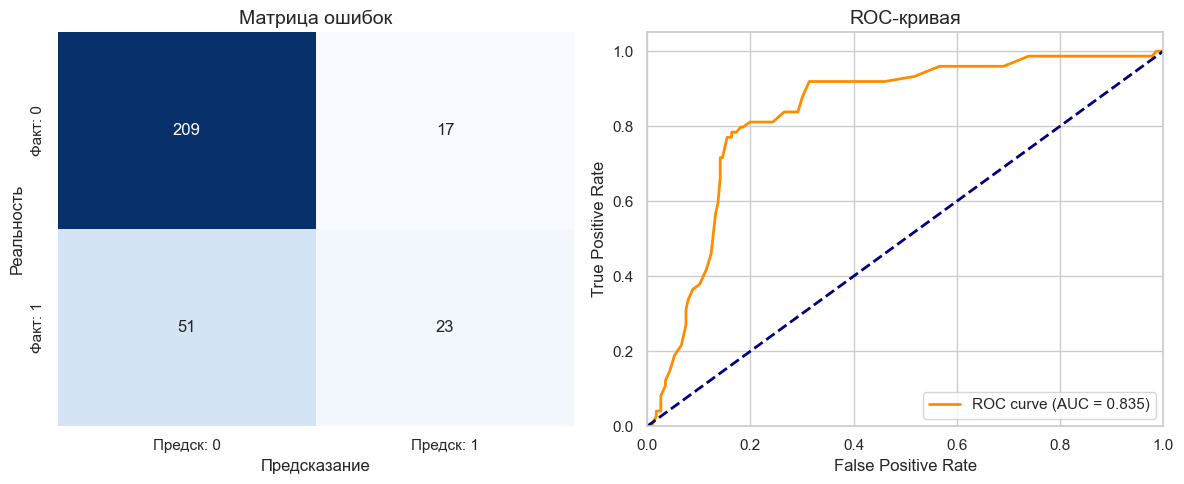

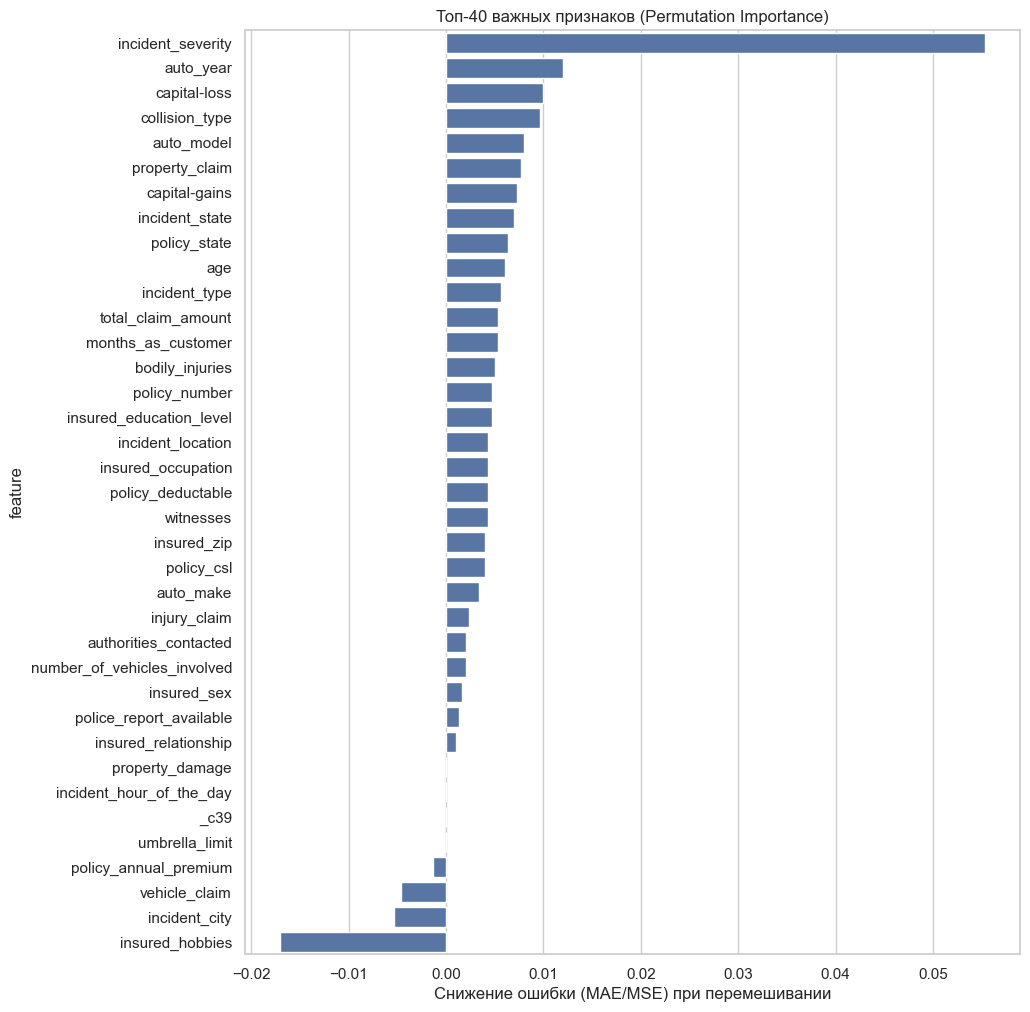

In [831]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
def graphics(y_test, y_pred, y_prob):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=['Предск: 0', 'Предск: 1'],
                yticklabels=['Факт: 0', 'Факт: 1'])
    plt.title("Матрица ошибок", fontsize=14)
    plt.ylabel("Реальность")
    plt.xlabel("Предсказание")

    plt.subplot(1, 2, 2)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая', fontsize=14)
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()
def feature_important(model, X_test, y_test):

    perm_result = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )

    perm_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': perm_result.importances_mean
    })

    top_40_perm = perm_df.sort_values(by='importance', ascending=False).head(40)

    plt.figure(figsize=(10, 12))
    sns.barplot(data=top_40_perm, x='importance', y='feature')
    plt.title("Топ-40 важных признаков (Permutation Importance)")
    plt.xlabel("Снижение ошибки (MAE/MSE) при перемешивании")
    plt.show()
graphics(y_test, y_pred, y_prob)
feature_important(model, X_test, y_test)

Случайный лес показывает неплохие метрики, однако он склонен приписывать всем честность. Нам такое не нравится, модель должна лучше определять недоминирующий класс.

### Improved Decision Tree

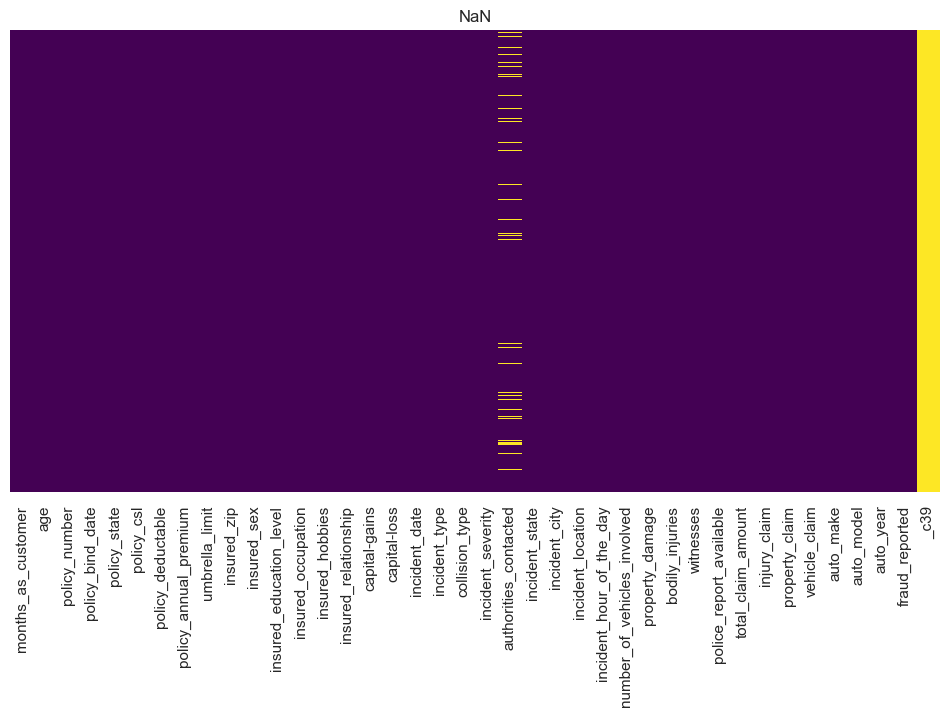

In [832]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "buntyshah/auto-insurance-claims-data/versions/1",
                                  "insurance_claims.csv")
df.head()

nulls = df.isna().sum().sort_values(ascending=False)
null_pct = (nulls / len(df)).mul(100).round(2)

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("NaN")
plt.show()

In [833]:
df_clean = df.copy()
df_clean["fraud_reported"].value_counts()

fraud_reported
N    753
Y    247
Name: count, dtype: int64

In [834]:
display(df_clean["police_report_available"].unique())
display(df_clean["property_damage"].unique())

array(['YES', '?', 'NO'], dtype=object)

array(['YES', '?', 'NO'], dtype=object)

In [835]:
df_clean = df_clean.drop(columns=["_c39"])

df_clean["authorities_contacted"] = df_clean["authorities_contacted"].fillna("No Contact")

TARGET_NAME = "fraud_reported"
df_clean["fraud_reported"] = df_clean["fraud_reported"].map({'Y': 1, 'N': 0})
df_clean["police_report_available"] = df_clean["police_report_available"].map({'YES': 1, 'NO': 0, '?': -1})
df_clean["property_damage"] = df_clean["property_damage"].map({'YES': 1, 'NO': 0, '?': -1})

dates_cols = ["policy_bind_date", "incident_date"]
for c in dates_cols:
    df_clean[c] = pd.to_datetime(df_clean[c])

df_clean

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,1,71610,6510,13020,52080,Saab,92x,2004,1
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,-1,5070,780,780,3510,Mercedes,E400,2007,1
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,0,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,0,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,0,6500,1300,650,4550,Accura,RSX,2009,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,...,1,-1,87200,17440,8720,61040,Honda,Accord,2006,0
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,...,3,-1,108480,18080,18080,72320,Volkswagen,Passat,2015,0
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,...,3,1,67500,7500,7500,52500,Suburu,Impreza,1996,0
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,...,1,1,46980,5220,5220,36540,Audi,A5,1998,0


In [836]:
num_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns.tolist()
df_clean[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
months_as_customer,1000.00,203.95,115.11,0.00,115.75,199.50,276.25,479.00
age,1000.00,38.95,9.14,19.00,32.00,38.00,44.00,64.00
policy_number,1000.00,546238.65,257063.01,100804.00,335980.25,533135.00,759099.75,999435.00
policy_deductable,1000.00,1136.00,611.86,500.00,500.00,1000.00,2000.00,2000.00
policy_annual_premium,1000.00,1256.41,244.17,433.33,1089.61,1257.20,1415.70,2047.59
umbrella_limit,1000.00,1101000.00,2297406.60,-1000000.00,0.00,0.00,0.00,10000000.00
insured_zip,1000.00,501214.49,71701.61,430104.00,448404.50,466445.50,603251.00,620962.00
capital-gains,1000.00,25126.10,27872.19,0.00,0.00,0.00,51025.00,100500.00
capital-loss,1000.00,-26793.70,28104.10,-111100.00,-51500.00,-23250.00,0.00,0.00
incident_hour_of_the_day,1000.00,11.64,6.95,0.00,6.00,12.00,17.00,23.00


In [837]:
import numpy as np

df_pr = df_clean.copy()

median_value = df_pr.loc[df_pr['umbrella_limit'] != -100000, 'umbrella_limit'].median()
df_pr.loc[df_pr['umbrella_limit'] == -100000, 'umbrella_limit'] = median_value

In [838]:
df_features = df_pr.copy()

df_clean["policy_tenure_months"] = ((df_clean["incident_date"] - df_clean["policy_bind_date"]).dt.days / 30).astype(int)

df_features["incident_year"] = df_features["incident_date"].dt.year
df_features["incident_month"] = df_features["incident_date"].dt.month
df_features["incident_dow"] = df_features["incident_date"].dt.dayofweek
df_features["is_weekend"] = df_features["incident_dow"].isin([5, 6]).astype(int)

df_features["injury_ratio"] = df_features["injury_claim"] / (df_features["total_claim_amount"] + 1e-3)
df_features["property_ratio"] = df_features["property_claim"]  / (df_features["total_claim_amount"] + 1e-3)
df_features["vehicle_ratio"] = df_features["vehicle_claim"] / (df_features["total_claim_amount"] + 1e-3)

drop_dates = ["policy_bind_date", "incident_date"]
df_features = df_features.drop(drop_dates, axis=1)

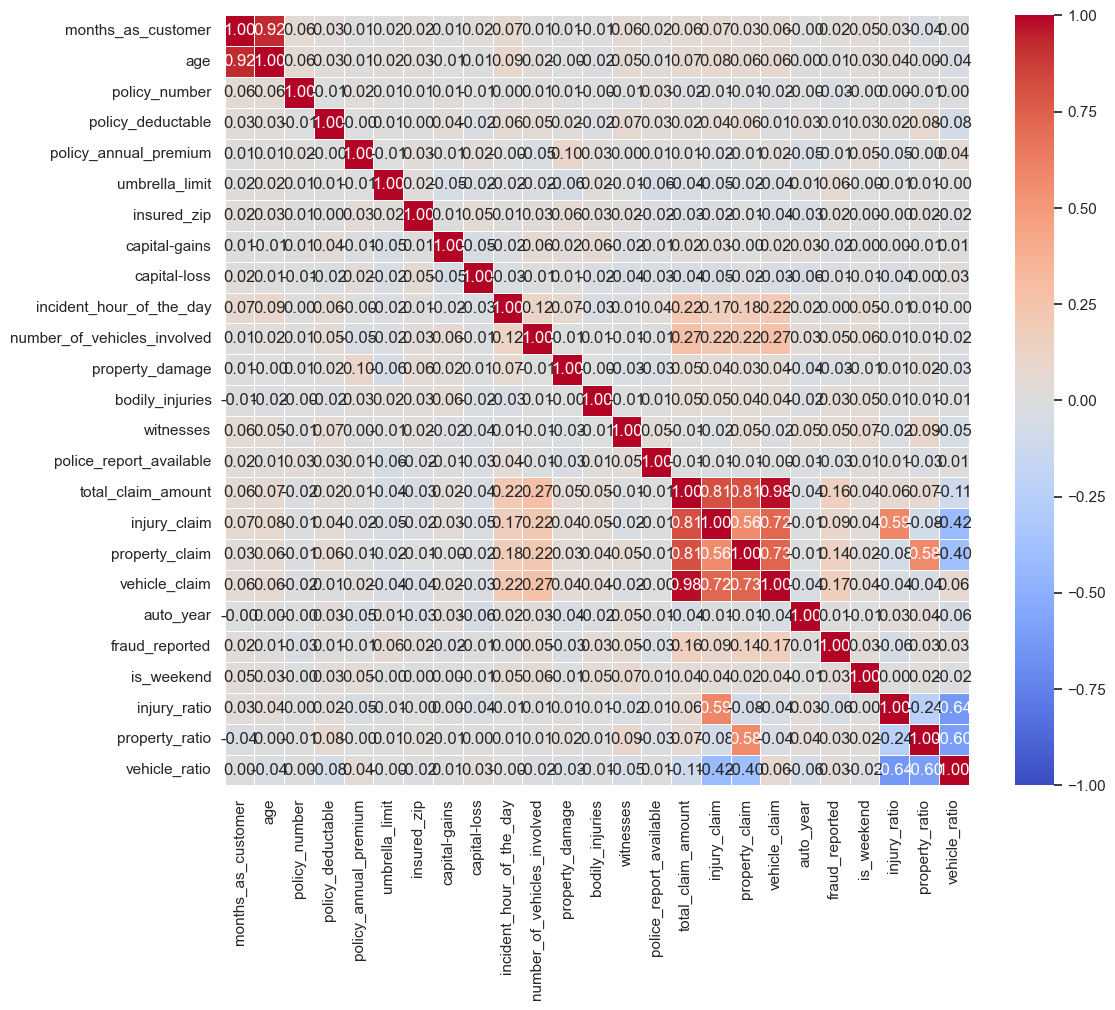

In [839]:
num_cols = df_features.select_dtypes(include=["int64", "float64"]).columns.tolist()

plt.figure(figsize=(12, 10))
correlation_matrix = df_features[num_cols].corr()

sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            vmin=-1, vmax=1,
            linewidths=0.5)

plt.show()

In [840]:
from sklearn.model_selection import train_test_split
X_i = df_features.drop(TARGET_NAME, axis=1)
y_i = df_features[TARGET_NAME]
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_i, y_i, test_size=0.25, random_state=42, stratify=y_i)

Я использовал BalancedRandomForestClassifier, оно даёт лучший скор на несбалансированных классах.

In [841]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


num_cols = X_train_i.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train_i.select_dtypes(include=["object", "category"]).columns.tolist()

categorical_pipe = Pipeline([
    ("onehot", OneHotEncoder(
        handle_unknown='infrequent_if_exist',
        sparse_output=False,
        min_frequency=2
    ))
])

ct = ColumnTransformer([
    ("cat", categorical_pipe, cat_cols)
])

model_pipe = Pipeline([
    ('ct', ct),
    ('model', BalancedRandomForestClassifier(random_state=42, n_estimators=500))
])

param_grid = {
    'model__n_estimators': [5, 50, 55],
    'model__max_depth': [10, 15, 20, None],
    'model__max_features': ['sqrt'],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4, 8],
    'model__class_weight': ['balanced'],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    model_pipe,
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_i, y_train_i)

print(f"Лучшие параметры: {grid.best_params_}")

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_i)
y_prob = best_model.predict_proba(X_test_i)[:, 1]

f1 = f1_score(y_test_i, y_pred)
roc = roc_auc_score(y_test_i, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print("-" * 30)
print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test_i, y_pred))
print("="*50)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Лучшие параметры: {'model__class_weight': 'balanced', 'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 50}
------------------------------
F1-score (класс 1): 0.7083
ROC-AUC: 0.8314
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       188
           1       0.62      0.82      0.71        62

    accuracy                           0.83       250
   macro avg       0.78      0.83      0.80       250
weighted avg       0.86      0.83      0.84       250



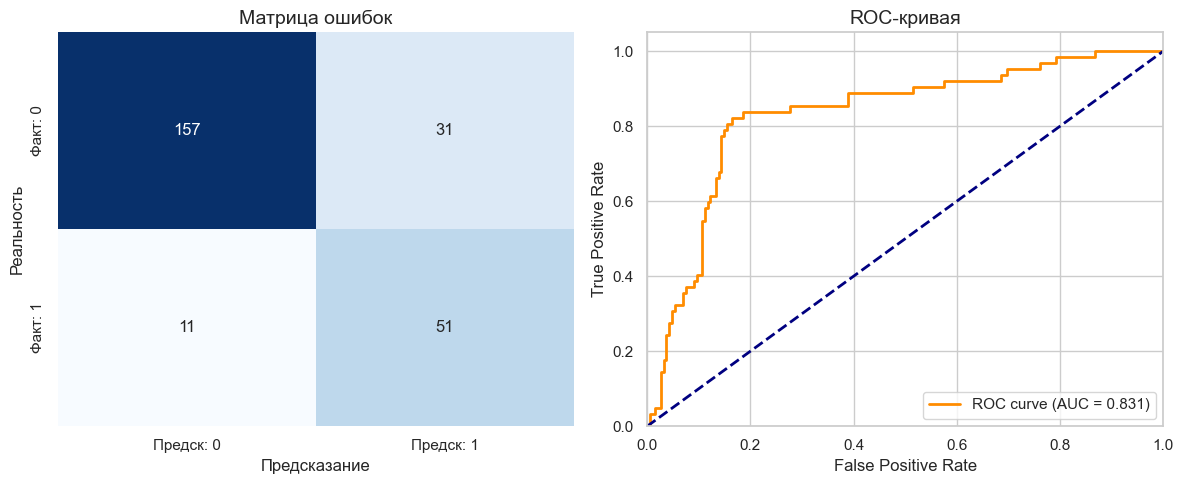

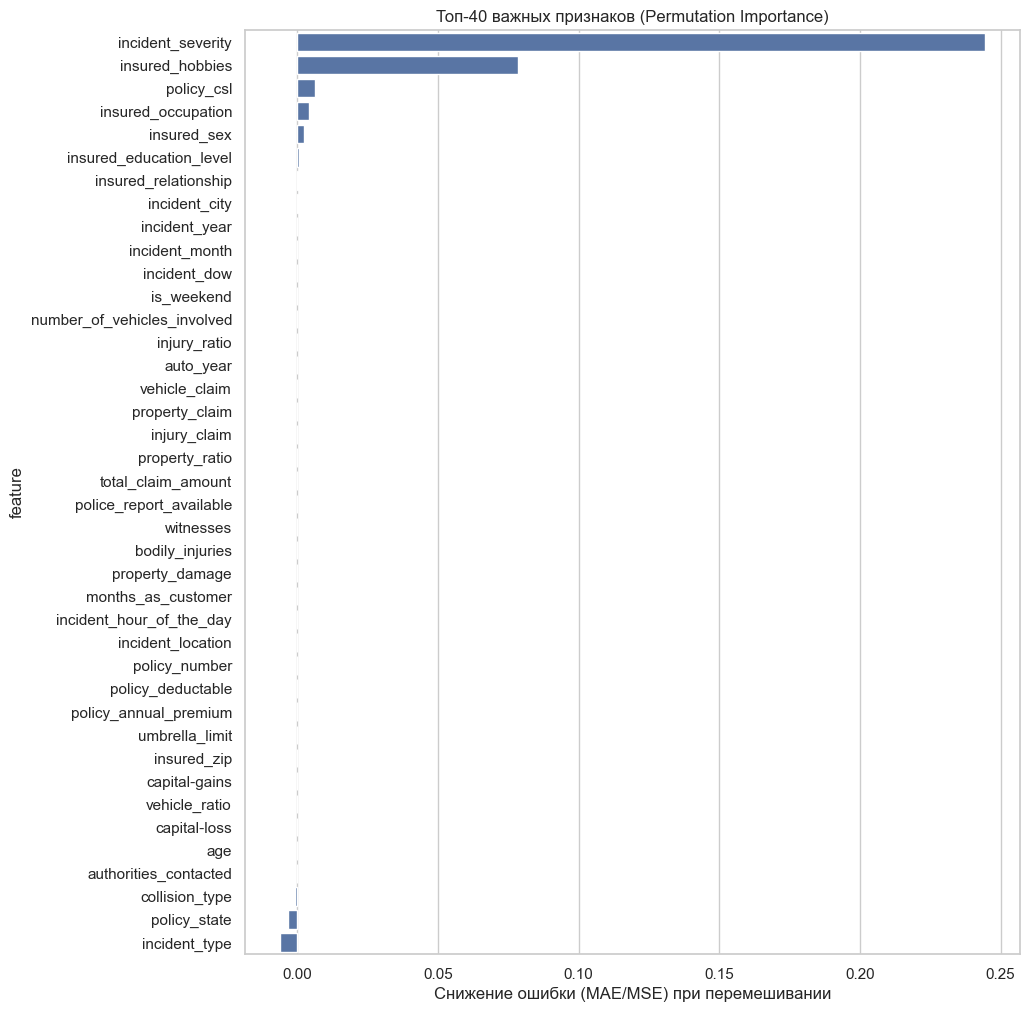

In [842]:
graphics(y_test_i, y_pred, y_prob)
feature_important(grid, X_test_i, y_test_i)

Лесу удалось хуже распознать мошенника. Даже использование балансного леса не помогло, ROC_AUC оказался хуже чем при использовании обычного решающего дерева.

Думаю, что это можно объяснить следующим образом. Как мы раньше видили, на то, является ли человек мошенником или нет влияет не так много факторов. Обучение каждого из деревьев леса происходит на случайной подвыборке, в которую этот сигнал может не попасть, поэтому он будет размыт другими факторами. Одиночное дерево же в свою очередь обучается на всей выборке, поэтому ему в этом плане легче.

### My implementation

In [843]:
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None,
                 value=None, proba=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.proba = proba

class MyDecisionTreeClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, max_depth=None, min_samples_leaf=1, min_samples_split=2, criterion='gini'):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.root = None

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.n_classes_ = len(self.classes_)
        self.n_features_ = X.shape[1]

        self.root = self._build_tree(X, y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return np.array([self._make_prediction(x, self.root) for x in X])

    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)

        probas = []
        for x in X:
            node_probs = self._get_node_proba(x, self.root)
            row_proba = [node_probs.get(c, 0.0) for c in self.classes_]
            probas.append(row_proba)

        return np.array(probas)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        unique_classes = len(np.unique(y))

        if (self.max_depth is not None and depth >= self.max_depth) or \
           (num_samples < self.min_samples_split or num_samples < self.min_samples_leaf * 2) or \
           (unique_classes == 1):
            return self._create_leaf_node(y)

        best_split = self._get_best_split(X, y, num_features)

        if best_split["gain"] > 0:
            left_subtree = self._build_tree(best_split["X_left"], best_split["y_left"], depth + 1)
            right_subtree = self._build_tree(best_split["X_right"], best_split["y_right"], depth + 1)
            return Node(
                feature_index=best_split["feature_index"],
                threshold=best_split["threshold"],
                left=left_subtree,
                right=right_subtree
            )

        return self._create_leaf_node(y)

    def _create_leaf_node(self, y):
        counts = Counter(y)
        most_common = counts.most_common(1)[0][0]
        total = len(y)
        probs = {cls: count / total for cls, count in counts.items()}
        return Node(value=most_common, proba=probs)

    def _get_best_split(self, X, y, num_features):
        best_split = {"gain": -1, "feature_index": None, "threshold": None}
        max_info_gain = -float("inf")
        parent_impurity = self._calculate_impurity(y)

        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                left_mask = feature_values <= threshold
                right_mask = ~left_mask
                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue

                y_left, y_right = y[left_mask], y[right_mask]
                n = len(y)
                n_l, n_r = len(y_left), len(y_right)
                child_impurity = (n_l / n) * self._calculate_impurity(y_left) + \
                                 (n_r / n) * self._calculate_impurity(y_right)
                info_gain = parent_impurity - child_impurity

                if info_gain > max_info_gain:
                    max_info_gain = info_gain
                    best_split = {
                        "feature_index": feature_index,
                        "threshold": threshold,
                        "X_left": X[left_mask],
                        "y_left": y_left,
                        "X_right": X[right_mask],
                        "y_right": y_right,
                        "gain": info_gain
                    }
        return best_split

    def _calculate_impurity(self, y):
        if len(y) == 0: return 0
        counts = np.unique(y, return_counts=True)[1]
        probabilities = counts / len(y)
        if self.criterion == 'gini':
            return 1 - np.sum(probabilities ** 2)
        elif self.criterion == 'entropy':
            return -np.sum(probabilities * np.log2(probabilities + 1e-9))
        else:
            raise ValueError("Unknown criterion. Use 'gini' or 'entropy'")

    def _make_prediction(self, x, node):
        if node.value is not None: return node.value
        if x[node.feature_index] <= node.threshold:
            return self._make_prediction(x, node.left)
        return self._make_prediction(x, node.right)

    def _get_node_proba(self, x, node):
        if node.proba is not None: return node.proba
        if x[node.feature_index] <= node.threshold:
            return self._get_node_proba(x, node.left)
        return self._get_node_proba(x, node.right)

class MyRandomForestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 n_estimators=100,
                 max_depth=None,
                 min_samples_leaf=1,
                 criterion='gini',
                 max_features="sqrt",
                 bootstrap=True,
                 random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state

        self.trees_ = []
        self.features_per_tree_ = []

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.n_classes_ = len(self.classes_)
        self.n_samples_, self.n_features_ = X.shape

        rng = np.random.default_rng(self.random_state)

        if self.max_features == "sqrt":
            self.max_features_ = int(np.sqrt(self.n_features_))
        elif self.max_features == "log2":
            self.max_features_ = int(np.log2(self.n_features_))
        elif isinstance(self.max_features, int):
            self.max_features_ = self.max_features
        elif isinstance(self.max_features, float):
            self.max_features_ = int(self.max_features * self.n_features_)
        else:
            self.max_features_ = self.n_features_

        self.trees_ = []
        self.features_per_tree_ = []

        for _ in range(self.n_estimators):
            if self.bootstrap:
                indices = rng.integers(0, self.n_samples_, size=self.n_samples_)
            else:
                indices = np.arange(self.n_samples_)

            X_sample = X[indices]
            y_sample = y[indices]

            feature_subset = rng.choice(
                self.n_features_,
                size=self.max_features_,
                replace=False
            )
            self.features_per_tree_.append(feature_subset)

            X_sub = X_sample[:, feature_subset]

            tree = MyDecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                criterion=self.criterion
            )
            tree.fit(X_sub, y_sample)
            self.trees_.append(tree)

        return self

    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)

        probas = np.zeros((len(X), self.n_classes_))

        for tree, features in zip(self.trees_, self.features_per_tree_):
            X_sub = X[:, features]
            probas += tree.predict_proba(X_sub)

        probas /= self.n_estimators
        return probas

    def predict(self, X):
        check_is_fitted(self)
        proba = self.predict_proba(X)
        class_indices = np.argmax(proba, axis=1)
        return self.classes_[class_indices]


In [844]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

F1-score (класс 1): 0.4174
ROC-AUC: 0.8329
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       226
           1       0.59      0.32      0.42        74

    accuracy                           0.78       300
   macro avg       0.70      0.62      0.64       300
weighted avg       0.75      0.78      0.75       300



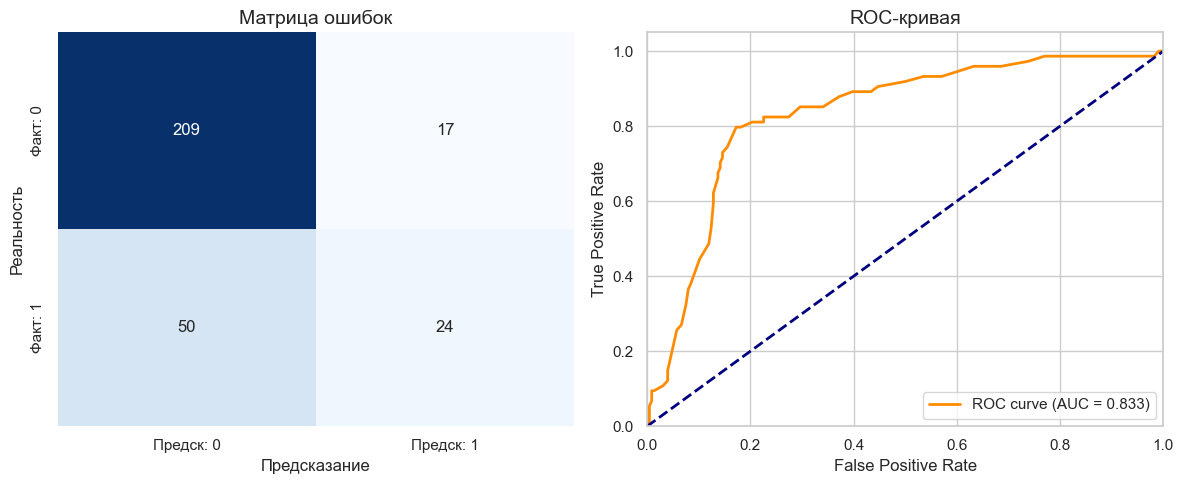

In [845]:
graphics(y_test, y_pred, y_prob)

In [846]:
model_pipe = Pipeline([
    ('ct', ct),
    ('model', MyDecisionTreeClassifier())
])

param_grid = {
    'model__max_depth': [10, 15, 20, None],
    'model__min_samples_leaf': [1, 2, 4, 8],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    model_pipe,
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_i, y_train_i)

print(f"Лучшие параметры: {grid.best_params_}")

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_i)
y_prob = best_model.predict_proba(X_test_i)[:, 1]

f1 = f1_score(y_test_i, y_pred)
roc = roc_auc_score(y_test_i, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print("-" * 30)
print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test_i, y_pred))
print("="*50)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие параметры: {'model__max_depth': 15, 'model__min_samples_leaf': 8}
------------------------------
F1-score (класс 1): 0.5862
ROC-AUC: 0.8515
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       188
           1       0.63      0.55      0.59        62

    accuracy                           0.81       250
   macro avg       0.74      0.72      0.73       250
weighted avg       0.80      0.81      0.80       250



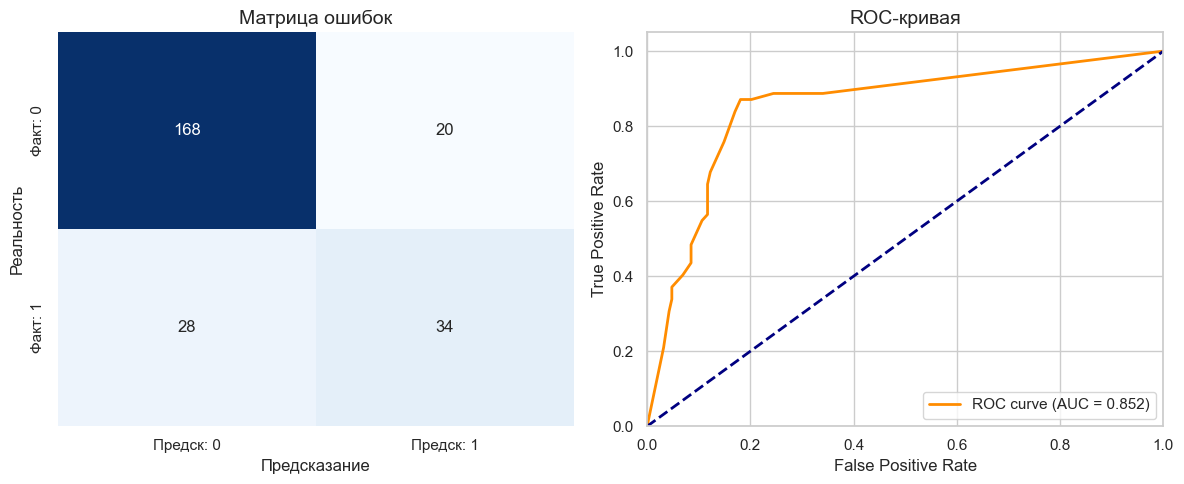

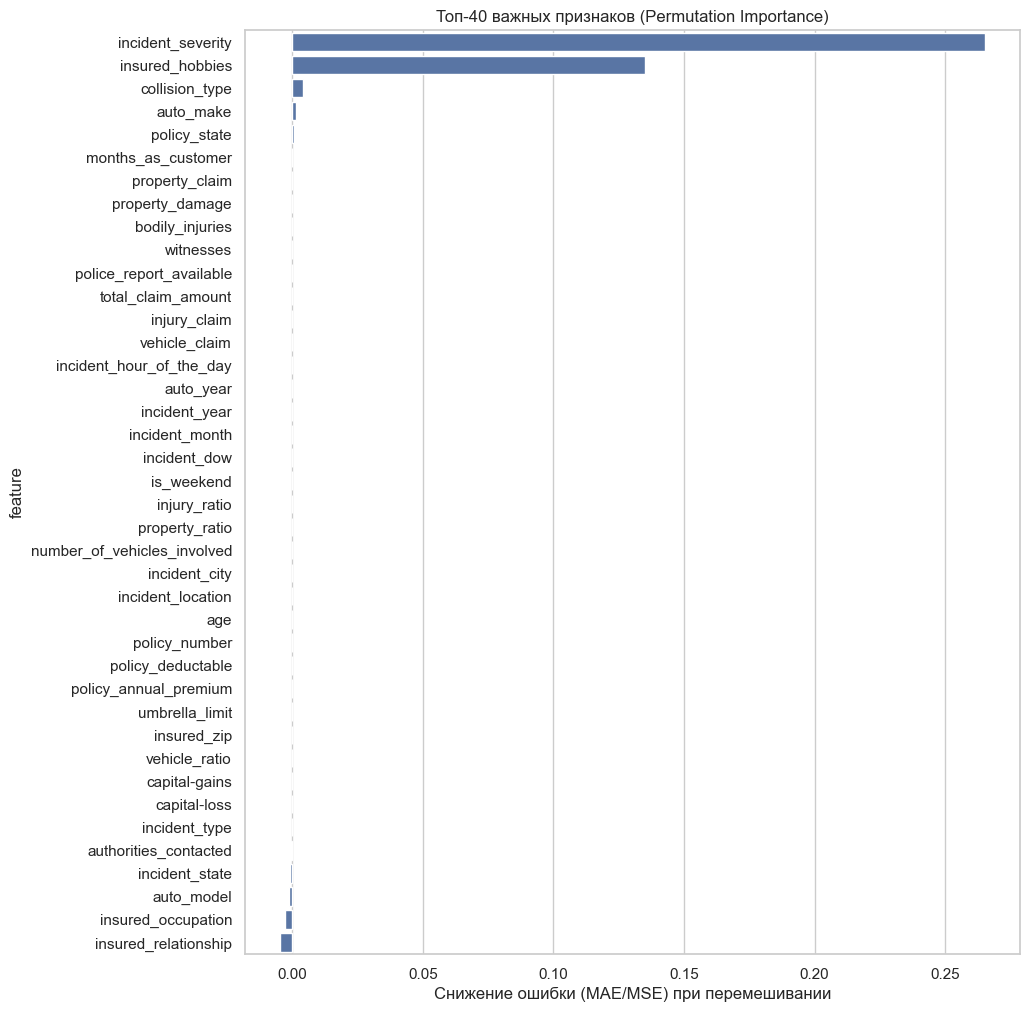

In [847]:
graphics(y_test_i, y_pred, y_prob)
feature_important(grid, X_test_i, y_test_i)

Собственная реализация работает чуть хуже, поскольку нет поддержки задания min_samples_split и class_weight, последний особенно сильно влияет на результат, поскольку классы в датасете несбалансированны.

|              | Base Random Forest | Random Forest | My Random Forest |
|--------------|--------------------|---------------|------------------|
| ROC_AUC      | 0.8398             | 0.8314        | 0.8515           |
| F1 (1 класс) | 0.85               | 0.88          | 0.88             |
| F1 (2 класс) | 0.39               | 0.71          | 0.59             |

## Вывод
Использование случайного леса в регрессии показывает результат около того, что показывала линейная регрессия, однако модель склонна переобучаться при неверно подобранных параметрах. В задаче классификации результат оказался лучше, модель показала очень даже неплохие результаты.